In [12]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

In [7]:
"""SCAFFOLD RUN
"""

import nest_asyncio
nest_asyncio.apply()

import collections
import functools
from typing import Callable, List, OrderedDict
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import scaffold_tf
from scaffold_tf import build_server_broadcast_message
from scaffold_tf import client_update
from scaffold_tf import get_model_weights
from scaffold_tf import server_update
from scaffold_tf import ServerState

from scaffold_tff import build_federated_averaging_process


def _create_test_cnn_model():
  """A simple CNN model for test."""
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  max_pool = functools.partial(
      tf.keras.layers.MaxPooling2D,
      pool_size=(2, 2),
      padding='same',
      data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu)

  model = tf.keras.models.Sequential([
      conv2d(filters=32, input_shape=input_shape),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Activation(tf.nn.softmax),
  ])

  return model

def _create_test_cnn_model_zero_weights():
  """A simple CNN model for test."""
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  max_pool = functools.partial(
      tf.keras.layers.MaxPooling2D,
      pool_size=(2, 2),
      padding='same',
      data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu,
      kernel_initializer='zeros')

  model = tf.keras.models.Sequential([
      conv2d(filters=32, input_shape=input_shape),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Activation(tf.nn.softmax),
  ])

  return model

def _simple_model_fn():
  keras_model = _create_test_cnn_model()
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  input_spec = collections.OrderedDict(
      x=tf.TensorSpec([None, 28, 28, 1], tf.float32),
      y=tf.TensorSpec([None], tf.int32))
  return scaffold_tf.KerasModelWrapper(
      keras_model=keras_model, input_spec=input_spec, loss=loss)
  
def _simple_model_fn_zero_weights():
  keras_model = _create_test_cnn_model_zero_weights()
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  input_spec = collections.OrderedDict(
      x=tf.TensorSpec([None, 28, 28, 1], tf.float32),
      y=tf.TensorSpec([None], tf.int32))
  return scaffold_tf.KerasModelWrapper(
      keras_model=keras_model, input_spec=input_spec, loss=loss)


def _create_one_client_state():
  return scaffold_tf.ClientState(client_index=-1, iters_count=0, client_controls=get_model_weights(_simple_model_fn_zero_weights()))

federated_algorithm = build_federated_averaging_process(_simple_model_fn, _create_one_client_state)

federated_data_type = federated_algorithm.next.type_signature.parameter[1]

server_state = federated_algorithm.initialize()

emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

NUM_CLIENTS = 100
BATCH_SIZE = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 28, 28, 1]), 
            element['label'])

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

client_ids = sorted(emnist_train.client_ids)[:NUM_CLIENTS]
federated_train_data = [preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in client_ids
]

client_states = [_create_one_client_state()] * NUM_CLIENTS

scaffold_loss_list = []
for i in range(50):
    server_state, loss, client_states = federated_algorithm.next(server_state, federated_train_data, client_states)
    scaffold_loss_list.append(loss)
    print("round", i+1, " loss=", loss)


round 1  loss= 2.5022123
round 2  loss= 2.3000505
round 3  loss= 2.2947204
round 4  loss= 2.289463
round 5  loss= 2.2854934
round 6  loss= 2.269195
round 7  loss= 2.2648747
round 8  loss= 2.2405207
round 9  loss= 2.2163649
round 10  loss= 2.1845207
round 11  loss= 2.1281335
round 12  loss= 2.082728
round 13  loss= 1.99605
round 14  loss= 1.9090844
round 15  loss= 1.7845854
round 16  loss= 1.6628194
round 17  loss= 1.5197469
round 18  loss= 1.381678
round 19  loss= 1.2428321
round 20  loss= 1.111368
round 21  loss= 1.0046619
round 22  loss= 0.9116221
round 23  loss= 0.83368653
round 24  loss= 0.7691226
round 25  loss= 0.7136764
round 26  loss= 0.6677795
round 27  loss= 0.62877685
round 28  loss= 0.5952253
round 29  loss= 0.56553894
round 30  loss= 0.54037124
round 31  loss= 0.51766574
round 32  loss= 0.49786797
round 33  loss= 0.4794582
round 34  loss= 0.4634889
round 35  loss= 0.4482691
round 36  loss= 0.4346596
round 37  loss= 0.42219228
round 38  loss= 0.41051924
round 39  loss= 0.39

In [8]:
"""FEDAVG RUN
"""

import nest_asyncio
nest_asyncio.apply()

import collections
import functools
from typing import Callable, List, OrderedDict
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import stateful_fedavg_tf
from stateful_fedavg_tf import build_server_broadcast_message
from stateful_fedavg_tf import client_update
from stateful_fedavg_tf import get_model_weights
from stateful_fedavg_tf import server_update
from stateful_fedavg_tf import ServerState

from stateful_fedavg_tff import build_federated_averaging_process


def _create_test_cnn_model():
  """A simple CNN model for test."""
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  max_pool = functools.partial(
      tf.keras.layers.MaxPooling2D,
      pool_size=(2, 2),
      padding='same',
      data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu)

  model = tf.keras.models.Sequential([
      conv2d(filters=32, input_shape=input_shape),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Activation(tf.nn.softmax),
  ])

  return model

def _simple_model_fn():
  keras_model = _create_test_cnn_model()
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  input_spec = collections.OrderedDict(
      x=tf.TensorSpec([None, 28, 28, 1], tf.float32),
      y=tf.TensorSpec([None], tf.int32))
  return stateful_fedavg_tf.KerasModelWrapper(
      keras_model=keras_model, input_spec=input_spec, loss=loss)

def _create_one_client_state():
  return stateful_fedavg_tf.ClientState(client_index=-1, iters_count=0)

federated_algorithm = build_federated_averaging_process(_simple_model_fn, _create_one_client_state)

federated_data_type = federated_algorithm.next.type_signature.parameter[1]

server_state = federated_algorithm.initialize()

emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

NUM_CLIENTS = 100
BATCH_SIZE = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 28, 28, 1]), 
            element['label'])

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

client_ids = sorted(emnist_train.client_ids)[:NUM_CLIENTS]
federated_train_data = [preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in client_ids
]

client_states = [_create_one_client_state()] * NUM_CLIENTS

fedavg_loss_list = []
for i in range(50):
    server_state, loss, client_states = federated_algorithm.next(server_state, federated_train_data, client_states)
    fedavg_loss_list.append(loss)
    print("round", i+1, " loss=", loss)


round 1  loss= 2.5243328
round 2  loss= 2.3046587
round 3  loss= 2.3017893
round 4  loss= 2.2956543
round 5  loss= 2.3001807
round 6  loss= 2.2881522
round 7  loss= 2.2809627
round 8  loss= 2.275004
round 9  loss= 2.2531083
round 10  loss= 2.2459044
round 11  loss= 2.2109199
round 12  loss= 2.1789773
round 13  loss= 2.139849
round 14  loss= 2.080008
round 15  loss= 2.011075
round 16  loss= 1.924639
round 17  loss= 1.8393962
round 18  loss= 1.7362804
round 19  loss= 1.6133263
round 20  loss= 1.4901867
round 21  loss= 1.3754895
round 22  loss= 1.2682383
round 23  loss= 1.1637337
round 24  loss= 1.0717795
round 25  loss= 0.99114853
round 26  loss= 0.92276365
round 27  loss= 0.85880214
round 28  loss= 0.80796987
round 29  loss= 0.75728685
round 30  loss= 0.71935016
round 31  loss= 0.6793367
round 32  loss= 0.649712
round 33  loss= 0.6176748
round 34  loss= 0.5944812
round 35  loss= 0.5687006
round 36  loss= 0.54973954
round 37  loss= 0.5282755
round 38  loss= 0.5122951
round 39  loss= 0.49

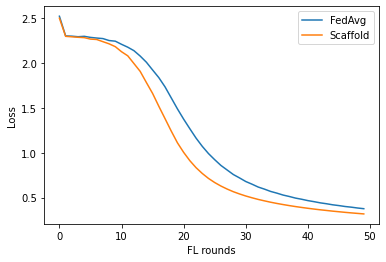

In [13]:
import matplotlib.pyplot as plt

plt.plot(fedavg_loss_list, label='FedAvg')
plt.plot(scaffold_loss_list, label='Scaffold')
plt.legend()
plt.xlabel("FL rounds")
plt.ylabel("Loss")
plt.show()